In [2]:
%cd /home/thucth/thucth/project/id_occlusion

/home/thucth/thucth/project/id_occlusion


## Prepare dataset

```
Create csv file with path _ label(float score)

Description:
- Dataset with multi level:
0: no occlusion (or occluded area is out of id)
1: 10% occlusion
2: 20% occlusion
3: 30% occlusion
4: 40% occlusion
5: 50% occlusion
.
.
```

### Inherit data from IQ006

In [3]:
import pandas as pd
import json 
categories_new = [
    {"id": 1, "name": 'corner_1'},
    {"id": 2, "name": 'corner_2'},
    {"id": 3, "name": 'corner_3'},
    {"id": 4, "name": 'corner_4'},
    {"id": 5, "name": 'full'}
]

categories_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'full': 5
}

categories_map_inverse = {
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "full"
}


In [4]:
import json
def read_from_cocojson(path_json):
    images_dict={}
    with open(path_json, 'r') as f:
        data = json.load(f)
        for ann in data['annotations']:
            if ann["image_id"] not in images_dict:
                images_dict[ann["image_id"]]={"bbox":{}}
            corner_type = categories_map_inverse[ann["category_id"]]
            #this is to convert from coco format into voc format
            images_dict[ann["image_id"]]["bbox"][corner_type] = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][2]+ann["bbox"][0], ann["bbox"][3]+ann["bbox"][1]]

        for img in data['images']:
            images_dict[img['id']]["path"]= img["file_name"]
            images_dict[img['id']]["width"] = img["width"]
            images_dict[img['id']]["height"] = img["height"]
    voc_data = [images_dict[k] for k in images_dict.keys()]
    return voc_data

### generate clear id

In [5]:
import csv
def generate_data_clear(voc_data, path_csv):
    print("Amount of source: ", len(voc_data))
    count=0
    f = open(path_csv, 'w')
    csv_writer = csv.writer(f)
    csv_writer.writerow(['path','score'])
    for sample in voc_data:
        if  len(sample['bbox'].keys())==5: #full corner
            csv_writer.writerow([sample['path'], 0])
            count+=1
    print("Amount of target: ", count)
    f.close()

split='train'
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
generate_data_clear(voc_data, "resources/data_occlusion_%s_clear.csv"%split)

Amount of source:  28095
Amount of target:  24464


### generate occluded id

In [217]:
from src.datasets import augment
import cv2
import os
import importlib
importlib.reload(augment)
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
random.seed(1101)
split='train'
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
df_id_clear = pd.read_csv("resources/data_occlusion_%s_clear.csv"%split)
path_backgrounds = list(df_id_clear['path'].values)
random.shuffle(path_backgrounds)

backegrounds=[]
backegrounds = augment.load_background(path_backgrounds, backegrounds) #use ref pass because we can disrupt but still have data
global_index=0
len_bg = len(backegrounds)
path2bbox={}
for sample_meta in tqdm(voc_data):
    path_image = os.path.basename(sample_meta['path'])
    bbox = sample_meta['bbox']
    path2bbox[path_image]=bbox  

100%|██████████| 28095/28095 [00:00<00:00, 137333.93it/s]


libpng warning: iCCP: known incorrect sRGB profile


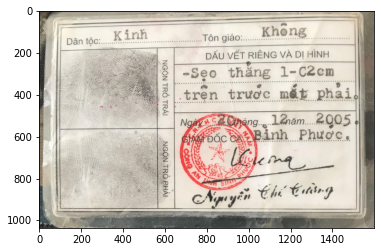

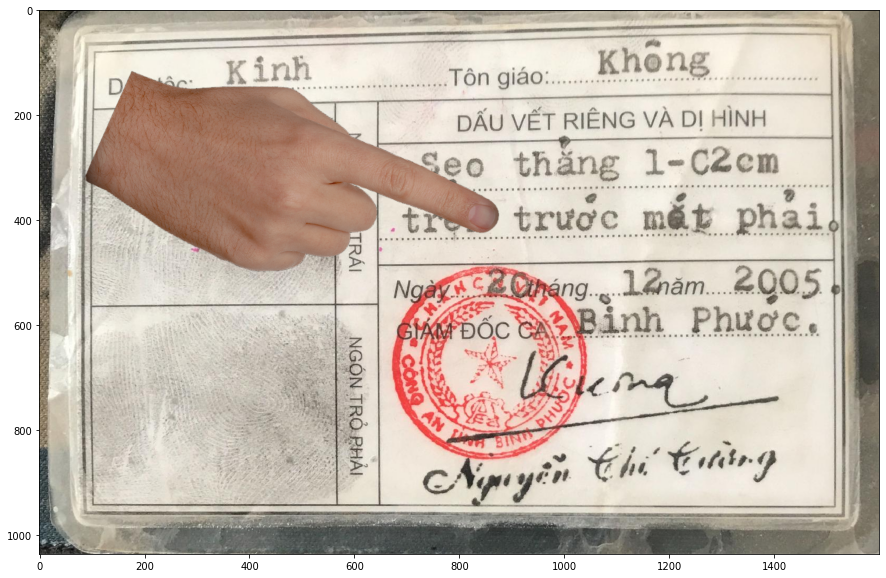

In [385]:
importlib.reload(augment)
foregrounds = augment.load_foreground(path="./resources/fg-hand")
percent = 0.2

# foregrounds = augment.load_foreground(path="./resources/fg-large")
# percent = 0.6

# foregrounds = augment.load_foreground(path="./resources/fg-small")
# percent = 0.05

img, name = backegrounds[2]
bbox = path2bbox[name]

plt.imshow(img)
plt.show()

c1 = augment.get_center(bbox['1'])
c2 = augment.get_center(bbox['2'])
theta = math.atan((c2[1]-c1[1])/(c2[0]-c1[0]))

rotated_img, angle, pad_h, pad_w, rot_mat = augment.padrotate_image(img, theta*180/math.pi)

corners = [augment.get_center(bbox[str(i)]) for i in range(1, 5)]
corners_trans = np.array(corners)
corners_trans[:, 0] += pad_w
corners_trans[:, 1] += pad_h

corners_rotated = np.array(corners_trans)@rot_mat[:, :2].T
corners_rotated += rot_mat[:, 2]
corners_rotated = corners_rotated.astype(int)

empty_bg = np.zeros((*rotated_img.shape[:2],4), dtype=np.int16)

output = augment.process_wrapper(empty_bg, \
    foregrounds, \
    percent=percent, \
    corners=corners_rotated, \
    is_debug=False)

# output,_ = augment.process(empty_bg, \

#     foregrounds[0], \
#     percent=percent, \
#     corners=corners_rotated, \
#     is_debug=True)


inv_fg = augment.unpadrotate_image(output, -angle, pad_h, pad_w)

# inv_fg[inv_fg[:,:,-1] == 0] = img[inv_fg[:,:,-1] == 0]

img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
img = img.astype(np.int16)
inv_fg = inv_fg.astype(np.int16)

alpha_channel = inv_fg[:,:,-1]
alpha_channel[alpha_channel>100] = 255
alpha_channel = cv2.GaussianBlur(alpha_channel,ksize=(3,3), sigmaX=0.5,sigmaY=0.5)
alpha_channel = alpha_channel[:,:,None]

img[:,:,:3] = inv_fg[:,:,:3]*(alpha_channel/255) +  img[:,:,:3]*((255-alpha_channel)/255)
img = img.astype(np.uint8)

plt.show()
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()


In [215]:
importlib.reload(augment)
global_index=0
len_bg = len(backegrounds)

def gen_data(amount, percent, foregrounds_path, dir_store, csv_file):
    global backegrounds
    global global_index
    os.makedirs(dir_store, exist_ok=True)
    if not os.path.exists(csv_file):
        f = open(csv_file, 'w')
        csv_writer = csv.writer(f)
        csv_writer.writerow(['path','score'])
    else:
        f = open(csv_file, 'a+')
        csv_writer = csv.writer(f)
    
    score = percent*100

    foregrounds = augment.load_foreground(path=foregrounds_path)
    err_paths=[]
    for _ in tqdm(range(amount)):
        global_index+=1
        img, name = backegrounds[global_index%len_bg]
        bbox = path2bbox[name]

        c1 = augment.get_center(bbox['1'])
        c2 = augment.get_center(bbox['2'])
        dy = (c2[1]-c1[1])
        dx = (c2[0]-c1[0])+1e-5
        theta = math.atan(dy/dx)
        if dx<0: theta+=math.pi
        
        rotated_img, angle, pad_h, pad_w, rot_mat = augment.padrotate_image(img, theta*180/math.pi)

        corners = [augment.get_center(bbox[str(i)]) for i in range(1, 5)]
        corners_trans = np.array(corners)
        corners_trans[:, 0] += pad_w
        corners_trans[:, 1] += pad_h

        corners_rotated = np.array(corners_trans)@rot_mat[:, :2].T
        corners_rotated += rot_mat[:, 2]
        corners_rotated = corners_rotated.astype(int)
        try:
            empty_bg = np.zeros((*rotated_img.shape[:2],4), dtype=np.int16)
            output = augment.process_wrapper(empty_bg, \
                foregrounds, \
                percent=percent, \
                corners=corners_rotated, \
                is_debug=False)
                
        except Exception as e:
            print(e)
            err_paths.append(global_index)
            continue
        inv_fg = augment.unpadrotate_image(output, -angle, pad_h, pad_w)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
        img = img.astype(np.int16)
        inv_fg = inv_fg.astype(np.int16)

        alpha_channel = inv_fg[:,:,-1]
        alpha_channel[alpha_channel>100] = 255
        alpha_channel = cv2.GaussianBlur(alpha_channel,ksize=(3,3), sigmaX=0.5,sigmaY=0.5)
        alpha_channel = alpha_channel[:,:,None]

        img[:,:,:3] = inv_fg[:,:,:3]*(alpha_channel/255) +  img[:,:,:3]*((255-alpha_channel)/255)
        img = img.astype(np.uint8)

        #write results
        idx_ext = name.rfind('.')
        name_store = name[:idx_ext]+ '_%s'%int(score) + name[idx_ext:]
    
        cv2.imwrite(os.path.join(dir_store, name_store), inv_fg[:,:,::-1])

        csv_writer.writerow([os.path.join(dir_store, name_store), int(score)])
    f.close()
    return err_paths


In [ ]:
percent=0.05

output_temp = "/share/team/thucth/data/id_occlusion/data_occlusion_%s_%s"%(split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp.replace("/share/team/thucth/data/id_occlusion", "./resources")+".csv"


err_paths = gen_data(amount=5000, \
    percent=percent, \
    foregrounds_path="./resources/fg-small", \
    dir_store=dir_store, \
    csv_file=csv_file)
print(len(err_paths))

In [219]:
percent=0.2

output_temp = "./resources/data_occlusion_%s_%s"%(split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp+".csv"


err_paths = gen_data(amount=5000, \
    percent=percent, \
    foregrounds_path="./resources/fg-small", \
    dir_store=dir_store, \
    csv_file=csv_file)
print(len(err_paths))

libpng warning: iCCP: known incorrect sRGB profile
  1%|          | 36/5000 [00:11<24:37,  3.36it/s]  

  3%|▎         | 162/5000 [00:51<14:41,  5.49it/s]  

  6%|▌         | 300/5000 [01:46<21:52,  3.58it/s]  

 51%|█████     | 2545/5000 [15:27<09:48,  4.17it/s]  

 55%|█████▍    | 2729/5000 [16:36<08:18,  4.56it/s]  

 67%|██████▋   | 3327/5000 [20:17<18:38,  1.50it/s]

 87%|████████▋ | 4343/5000 [26:43<09:14,  1.19it/s]

100%|██████████| 5000/5000 [31:06<00:00,  2.68it/s]

7


In [220]:
percent=0.4

output_temp = "./resources/data_occlusion_%s_%s"%(split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp+".csv"


err_paths = gen_data(amount=5000, \
    percent=percent, \
    foregrounds_path="./resources/fg-hand", \
    dir_store=dir_store, \
    csv_file=csv_file)
print(len(err_paths))

libpng warning: iCCP: known incorrect sRGB profile
  1%|          | 37/5000 [00:12<27:44,  2.98it/s] 

  3%|▎         | 160/5000 [00:58<27:50,  2.90it/s]  

  6%|▌         | 300/5000 [02:06<24:47,  3.16it/s]  

 51%|█████     | 2545/5000 [18:14<12:25,  3.29it/s]  

 55%|█████▍    | 2729/5000 [19:35<12:57,  2.92it/s]

 67%|██████▋   | 3329/5000 [23:45<07:15,  3.83it/s]

 87%|████████▋ | 4343/5000 [30:54<04:23,  2.49it/s]

100%|██████████| 5000/5000 [35:43<00:00,  2.33it/s]

7


In [223]:
global_index=0
len_bg = len(backegrounds)

def gen_data(amount, percent, foregrounds_path, dir_store, csv_file):
    global backegrounds
    global global_index
    os.makedirs(dir_store, exist_ok=True)
    if not os.path.exists(csv_file):
        f = open(csv_file, 'w')
        csv_writer = csv.writer(f)
        csv_writer.writerow(['path','score'])
    else:
        f = open(csv_file, 'a+')
        csv_writer = csv.writer(f)
    
    score = percent*100

    foregrounds = augment.load_foreground(path=foregrounds_path)
    err_paths=[]
    for _ in tqdm(range(amount)):
        global_index+=1
        img, name = backegrounds[global_index%len_bg]
        bbox = path2bbox[name]

        c1 = augment.get_center(bbox['1'])
        c2 = augment.get_center(bbox['2'])
        dy = (c2[1]-c1[1])
        dx = (c2[0]-c1[0])+1e-5
        theta = math.atan(dy/dx)
        if dx<0: theta+=math.pi
        
        rotated_img, angle, pad_h, pad_w, rot_mat = augment.padrotate_image(img, theta*180/math.pi)

        corners = [augment.get_center(bbox[str(i)]) for i in range(1, 5)]
        corners_trans = np.array(corners)
        corners_trans[:, 0] += pad_w
        corners_trans[:, 1] += pad_h

        corners_rotated = np.array(corners_trans)@rot_mat[:, :2].T
        corners_rotated += rot_mat[:, 2]
        corners_rotated = corners_rotated.astype(int)
        try:
            empty_bg = np.zeros((*rotated_img.shape[:2],4), dtype=np.int16)
            output = augment.process_wrapper(empty_bg, \
                foregrounds, \
                percent=percent, \
                corners=corners_rotated, \
                is_debug=False)
                
        except Exception as e:
            print(e)
            err_paths.append(global_index)
            continue
        inv_fg = augment.unpadrotate_image(output, -angle, pad_h, pad_w)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
        img = img.astype(np.int16)
        inv_fg = inv_fg.astype(np.int16)

        alpha_channel = inv_fg[:,:,-1]
        alpha_channel[alpha_channel>100] = 255
        alpha_channel = cv2.GaussianBlur(alpha_channel,ksize=(3,3), sigmaX=0.5,sigmaY=0.5)
        alpha_channel = alpha_channel[:,:,None]

        img[:,:,:3] = inv_fg[:,:,:3]*(alpha_channel/255) +  img[:,:,:3]*((255-alpha_channel)/255)
        img = img.astype(np.uint8)

        #write results
        idx_ext = name.rfind('.')
        name_store = name[:idx_ext]+ '_%s'%int(score) + name[idx_ext:]
    
        cv2.imwrite(os.path.join(dir_store, name_store), inv_fg[:,:,::-1])

        csv_writer.writerow([os.path.join(dir_store, name_store), int(score)])
    f.close()
    return err_paths


In [ ]:

percent=0.6

output_temp = "./resources/data_occlusion_%s_%s"%(split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp+".csv"


err_paths = gen_data(amount=5000, \
    percent=percent, \
    foregrounds_path="./resources/fg-large", \
    dir_store=dir_store, \
    csv_file=csv_file)
print(len(err_paths))

In [ ]:
percent=0.8

output_temp = "./resources/data_occlusion_%s_%s"%(split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp+".csv"


err_paths = gen_data(amount=5000, \
    percent=percent, \
    foregrounds_path="./resources/fg-large", \
    dir_store=dir_store, \
    csv_file=csv_file)
print(len(err_paths))